# DATA INVESTIGATION
    ## Analysis on BeerAdvocate
        #### Understanding data structure
        ### Handling missing values
        ### Checking for data inconsistencies
        ### Initial data analysis
            #### Initial analysis on BeerTypes
            #### Initial analysis on Grading columns
            #### Initial analysis on grading over time
                ##### Days of the week analysis
                ##### Monthly analysis
            

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

## Analysis on BeerAdvocate

### Understanding data structure

Load data from pickles. To obtain pickles run the notebook _data_import.ipynb_

In [24]:
# load Beer Advocate data from pickles
ratings = pd.read_pickle('./datasets/BeerAdvocate/ratings.pkl')
reviews = pd.read_pickle('./datasets/BeerAdvocate/reviews.pkl')

In [25]:
print('Ratings - Rows: {}, columns {}'.format(ratings.shape[0], ratings.shape[1]))
print('Reviews - Rows: {}, columns {}'.format(reviews.shape[0], reviews.shape[1]))
reviews.sample(2)

Ratings - Rows: 8393032, columns 17
Reviews - Rows: 2589586, columns 17


,Beer Name,Beer Id,Brewery Name,Brewery Id,Style,Abv,Date,Username,User Id,Appearance,Aroma,Palate,Taste,Overall,Rating,Text,Review
2338680,Unicorn's Revenge,90661,Pipeworks Brewing Company,28178,American Double / Imperial IPA,10.0,2013-08-08 12:00:00,ehammond1,ehammond1.232453,4.25,4.25,4.25,4.0,4.25,4.15,"Bottle (2013)Acquired via tradeThanks, Hugonau...",None
2501653,Foret,2430,Brasserie Dupont sprl,637,Saison / Farmhouse Ale,7.5,2007-05-21 12:00:00,rhoadsrage,rhoadsrage.6920,4.00,4.00,4.00,4.5,4.00,4.20,(Served in a chalice)A- This beer has a hazy d...,None


Rating column is calculated as $Rating = 0.06 * Appearance + 0.24 * Aroma + 0.10 * Palate + 0.40 * Taste  + 0.20 * Overall$. 
Therefore the sorted (by weight) aspects are taste, smell, overall, feel and look. We should be aware of this linear dependence of columns when making conclusions.

We have two datasets ratings and reviews. Let's understand what do they represent and what are the differences between them. We can notice that the 'Review' column has None value for both sample rows from reviews dataframe. It turns out this is the case for each of the rows:

In [28]:
print('Reviews - count of None values in \'Review\' column: {}'.format(reviews['Review'].isna().sum()))

Reviews - count of None values in 'Review' column: 2589586


We can also observe that this value coincides with the count of 'True' values in 'Review' column of ratings dataframe:

In [29]:
print('Ratings - count of True values in \'Review\' column: {}'.format(ratings['Review'].sum()))

Ratings - count of True values in 'Review' column: 2589586


This hints us towards the conclusion that 'Review' column in ratings dataframe indicates wether textual review of beer exists. This however isn't the case, since we can observe that in ~120k rows textual review exists and column is set to False:

In [30]:
print('Ratings - count of non-empty texts values in \'Text\' column: {}'.format(ratings['Text'].notna().sum()))

Ratings - count of non-empty texts values in 'Text' column: 2715712


In [31]:
ratings[(ratings['Review']==False)&(ratings['Text'].notna())].head()

,Beer Name,Beer Id,Brewery Name,Brewery Id,Style,Abv,Date,Username,User Id,Appearance,Aroma,Palate,Taste,Overall,Rating,Text,Review
153,Sheelin Blonde Ale,153718,The Sheelin Brewery,32848,American Blonde Ale,NaN,2015-06-13 12:00:00,beerinabottle,beerinabottle.811533,4.25,4.25,4.50,4.75,4.50,4.53,500 ml bottle picked up in a visit to the home...,False
155,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2016-12-31 12:00:00,awjess,awjess.1185716,4.50,4.00,4.25,4.00,4.25,4.11,"Look - Has a nice foamy head, Feel - Creamy ...",False
160,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2015-08-19 12:00:00,papat444,papat444.113971,3.75,3.75,3.75,3.75,3.75,3.75,Flashback #355,False
162,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2015-03-29 12:00:00,nelsonsaigon,nelsonsaigon.897449,3.50,3.50,3.50,3.50,3.50,3.50,Saigon (can)I am neutral on this beer.,False
164,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2014-12-26 12:00:00,Jake_eff,jake_eff.906786,4.25,3.50,4.50,4.75,4.75,4.40,"Had this once in NYC on tap, caught me off guard.",False


Since all three values are the relatively close, it seems that the reviews dataset is a subset of ratings dataframe. We will now investigate this further.

First, we check if there are any duplicates in either of dataframes:

In [32]:
print('Duplicated rows in ratings : {}'.format(sum(ratings.duplicated())))
print('Duplicated rows in reviews : {}'.format(sum(reviews.duplicated())))

Duplicated rows in ratings : 0
Duplicated rows in reviews : 0


We will now confirm if each row from the Reviews dataframe also exists in the Ratings dataframe

In [33]:
# Since there are no duplicates in both dataframes, we compare the len of the intersection and the length of 
# the smaller dataframe. We obtain the intersection by merging between ratings and reviews
# We exclude only Review column for merge since it's None in reviews
assert len(ratings.merge(reviews, how='inner', on=ratings.columns.to_list()[:16])) == len(reviews)

Since the lengths are the same, we conclude the reviews dataframe is strict subset of ratings dataframe and we continue the analysis **only for reviews** dataframe.

### Handling missing values

We investigate missing values. We first find the number of ratings for an unknown beer:

In [35]:
print('Number of reviews with unknwon beer id: {}'.format(reviews['Beer Id'].isna().sum()))

Number of reviews with unknwon beer id: 0


We always know who rated the beer and when the beer is rated : 

In [36]:
assert len(reviews) == len(reviews[reviews['User Id'].notna()])
assert len(reviews) == len(reviews[reviews['Date'].notna()])

##### How many datapoints do not have grades for certain aspects, total rating or review?

In [103]:
# review (subset of ratings)
interesting_columns = ['Appearance','Aroma','Palate','Taste','Overall','Rating','Text']

display_df = {'Percentage of present entries (%)': 
    [100*len(ratings[ratings[column].notna()])/len(ratings) for column in interesting_columns], 
     'Variables': interesting_columns}

# create dataframe to display percentages of non-null values
power_stats_dataframe = pd.DataFrame.from_dict(data=display_df).set_index('Variables')
power_stats_dataframe.transpose().style.set_caption('Beer Advocate Reviews :').format(precision=3)

Variables,Appearance,Aroma,Palate,Taste,Overall,Rating,Text
Percentage of present entries (%),56.829,56.829,56.829,56.829,56.829,100.000,32.357


We see that rating and text are present even when other aspects are not.

##  TODO : understand what is rating if all other stuff are missing

The presence of non-values for Appearance, Aroma, Palate, Taste and Overall are the same. Do they correspond to the same datapoints?

In [38]:
print('Reviews - Correspond to the same datapoints: ')
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Aroma'].isna()])) and \
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Taste'].isna()])) and \
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Overall'].isna()]))

Reviews - Correspond to the same datapoints: 


True

Currently on Beer Advocate, if one does not rate an aspect the overall grade is used for the aspects grade. Since we confirmed missing values correspond to the same ratings, it can be that overall grade is used for other aspects if the grades for other aspects are missing. 

Therefore, the reviews that have an aspect missing, have all the aspects missing.
Since there are 1.24% of missing aspects in the Ratings, we won't discard them, but we will be aware of them.

### Checking for data inconsistencies

Are there multiple reviews from the same user for the same beer? 

In [39]:
multiple_reviews = reviews.groupby(['Beer Id','User Id']).agg('count') > 1
if sum(multiple_reviews.any()) == 0:
    print('No repetitions for the same beer and user')

No repetitions for the same beer and user


Is there an invalid rating (ie. not in range 1-5)?

In [40]:
assert len(reviews[(reviews['Appearance'] < 1) | (reviews['Appearance'] > 5)]) == 0
assert len(reviews[(reviews['Aroma'] < 1) | (reviews['Aroma'] > 5)]) == 0
assert len(reviews[(reviews['Taste'] < 1) | (reviews['Taste'] > 5)]) == 0
assert len(reviews[(reviews['Overall'] < 1) | (reviews['Overall'] > 5)]) == 0
assert len(reviews[(reviews['Rating'] < 1) | (reviews['Rating'] > 5)]) == 0

Is there invalid ABVs?

In [41]:
assert len(reviews[reviews['Abv'] < 0]) == 0
assert len(reviews[reviews['Abv'] > 70]) == 0

We can conclude that ratings and ABV values are consistent in BeerAdvocate datasets.

## Initial data analysis

#### Initial analysis on Style
Each beer has its Style. Let's group the beers based on style and have a glane at the data.

In [42]:
# group by styles and take means (meaningful for given grades)
reviews_by_style = reviews.groupby('Style').mean().sort_values('Overall')
reviews_by_style

,Beer Id,Brewery Id,Abv,Appearance,Aroma,Palate,Taste,Overall,Rating
Style,,,,,,,,,
Low Alcohol Beer,31956.218192,2032.512182,0.597968,3.000137,2.566749,2.595395,2.525082,2.625000,2.587120
Light Lager,17856.315424,1235.20067,4.087630,2.512368,2.240667,2.416415,2.338357,2.656071,2.398906
American Malt Liquor,31798.391481,2109.482574,7.470050,2.882770,2.501213,2.702959,2.589509,2.695632,2.616072
Euro Strong Lager,28957.766329,3369.711149,8.231843,3.218546,2.869935,2.955441,2.819000,2.857112,2.877638
American Adjunct Lager,11708.084182,1908.012777,4.856642,2.854214,2.535443,2.788226,2.722557,2.957232,2.741665
...,...,...,...,...,...,...,...,...,...
Russian Imperial Stout,41034.813736,5822.344282,10.284634,4.201200,4.088503,4.098884,4.148977,4.067590,4.117956
American Wild Ale,101010.895211,12455.584441,7.281400,3.992019,4.081268,4.029354,4.108408,4.074859,4.081156
Quadrupel (Quad),36351.128563,4176.793527,10.632953,4.100852,4.123473,4.107912,4.188342,4.094184,4.141814


There are 104 beer styles. 
It seems that better rated beers have higher ABV. We can execute further analysis to conclude it.

In [44]:
# top half styles (by Overall grade)
reviews_style_head = reviews_by_style.head(52)
# bottom half styles (by Overall grade)
reviews_style_tail = reviews_by_style.tail(52)
# compare alcholol levels for top and bottom halves
print('Mean of ABV for 5 worst rated beer styles: {:.4f} %'.format(reviews_style_head['Abv'].mean()))
print('Mean of ABV for 5 best rated beer styles: {:.4f} %'.format(reviews_style_tail['Abv'].mean()))

Mean of ABV for 5 worst rated beer styles: 5.6939 %
Mean of ABV for 5 best rated beer styles: 7.3981 %


It seems like the beers with higher ABV are more liked. We execute the test to compare the findings. Populations are bottom ABV and top ABV halves and we compare are the means of the overall ratings different for these populations.

In [46]:
# is there a difference in ratings between beers with lower and high alcohol levels
reviews_by_style = reviews.groupby('Style').mean().sort_values('Abv')
# less alcohol
reviews_style_head = reviews_by_style.head(52)
# more alcohol
reviews_style_tail = reviews_by_style.tail(52)
t_indep = scipy.stats.ttest_ind(reviews_style_head['Overall'], reviews_style_tail['Overall'], equal_var=False)
t_indep

Ttest_indResult(statistic=-3.150570509820446, pvalue=0.002160153166590943)

We reject the null hypothesis the means are the same. Since the test statistic is negative and the first group is the group with lower ABV, we conclude that beers with higher ABV obtain better ratings. 

#### Initial analysis on Grading columns

People rated different aspects of beers, namely appearance, aroma, palate, taste and overall. We visually inspect what are the distributions of grades. We show only granularity by full grades, since people rarely gave grades which end on 0.25 or 0.75.

In [107]:
grading_columns = ['Appearance', 'Aroma', 'Palate', 'Taste', 'Overall', 'Rating'] #columns that are graded
colors = dict(zip(grading_columns,['green','red','blue','orange','magenta','gray'])) #separate color for each graded column

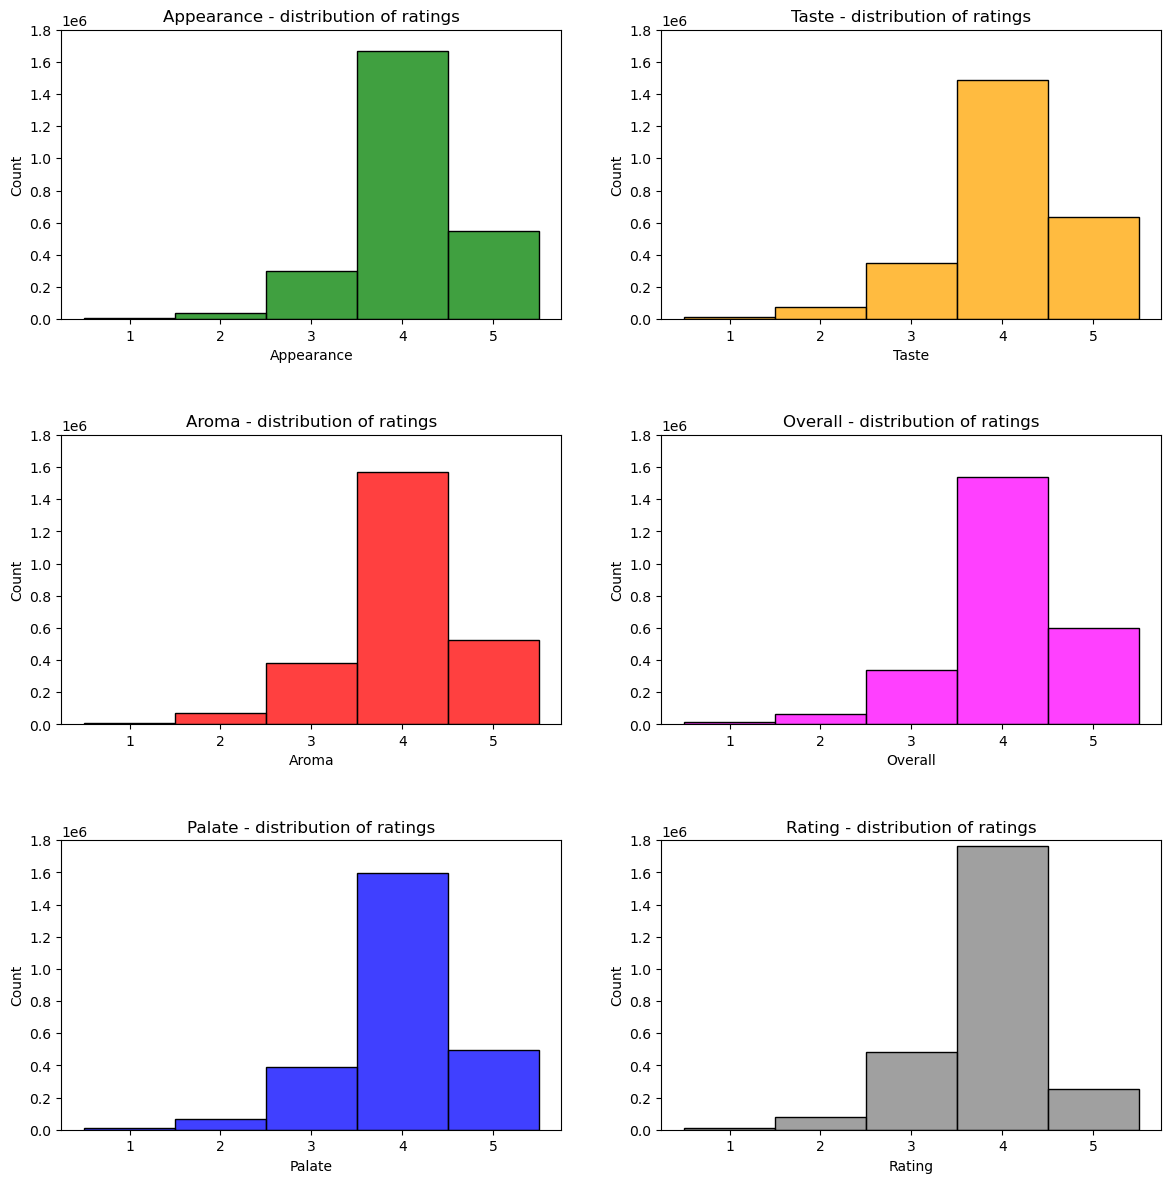

In [108]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)

    
for grading_index in range(len(grading_columns)):
    sns.histplot(ax=axes[grading_index%3, grading_index//3], data = reviews[grading_columns[grading_index]], discrete=True, color = colors[grading_columns[grading_index]])
    axes[grading_index%3, grading_index//3].set_ylim([0,1.8e6]) #set the same interval for y axis
    axes[grading_index%3, grading_index//3].set_title(grading_columns[grading_index] + ' - distribution of ratings')

# set figure size
fig.set_size_inches(11, 11)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)

We can observe that the distribution of ratings over different aspects is quite similar.

#### Initial analysis on grading over time

##### Days of the week analysis

In [109]:
reviews['Weekday'] = reviews['Date'].apply(lambda x: x.weekday()) #adding Weekday data

[Text(0.5, 1.0, 'Number of reviews per each day of the week')]

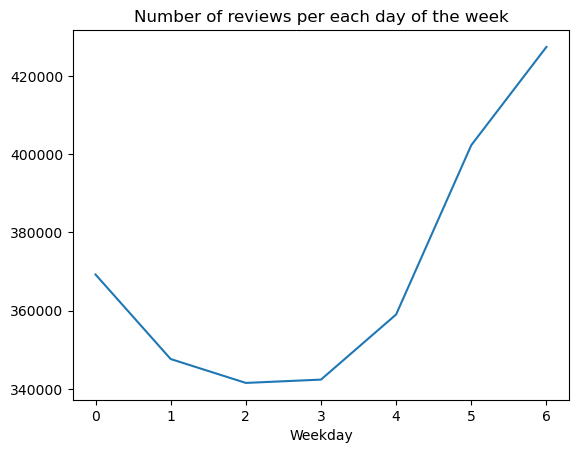

In [110]:
#Plotting number of reviews per each day of the week
sns.lineplot(data = reviews.groupby('Weekday').size()).set(title = 'Number of reviews per each day of the week')

Line plot indicates that the number of reviews during weekends is slightly higher. The greatest number of reviews was written on Sundays, and the least number of reviews was written on Tuesdays:

In [111]:
print ('Sunday : {}'.format((reviews['weekday']==6).sum())) #Total numver of reviews written on Sundays
print ('Saturday : {}'.format((reviews['weekday']==5).sum())) #Total numver of reviews written on Saturdays
print ('Tuesday : {}'.format((reviews['weekday']==2).sum())) #Total numver of reviews written on Tuesdays

Sunday : 427485
Saturday : 402344
Tuesday : 341508


## TODO : comment differences between Tuesday and Weekend

In [113]:
reviews_by_weekday = reviews[grading_columns + ['Weekday']].groupby('Weekday').mean() #Mean of rating of each graded column
reviews_by_weekday

,Appearance,Aroma,Palate,Taste,Overall,Rating
Weekday,,,,,,
0,3.881407,3.795567,3.799598,3.837270,3.846429,3.829199
1,3.876397,3.788904,3.790816,3.826788,3.839819,3.821201
2,3.877436,3.788640,3.790875,3.828726,3.842240,3.822558
3,3.882183,3.791006,3.794766,3.831793,3.843892,3.825218
4,3.884315,3.792076,3.795879,3.833920,3.844856,3.826762
5,3.894303,3.801849,3.806776,3.843889,3.850008,3.835674
6,3.890663,3.802361,3.808417,3.847601,3.853737,3.837931


From the dataframe, we can notice the trend of ratings increasing towards the ending of the week. We will plot this data:

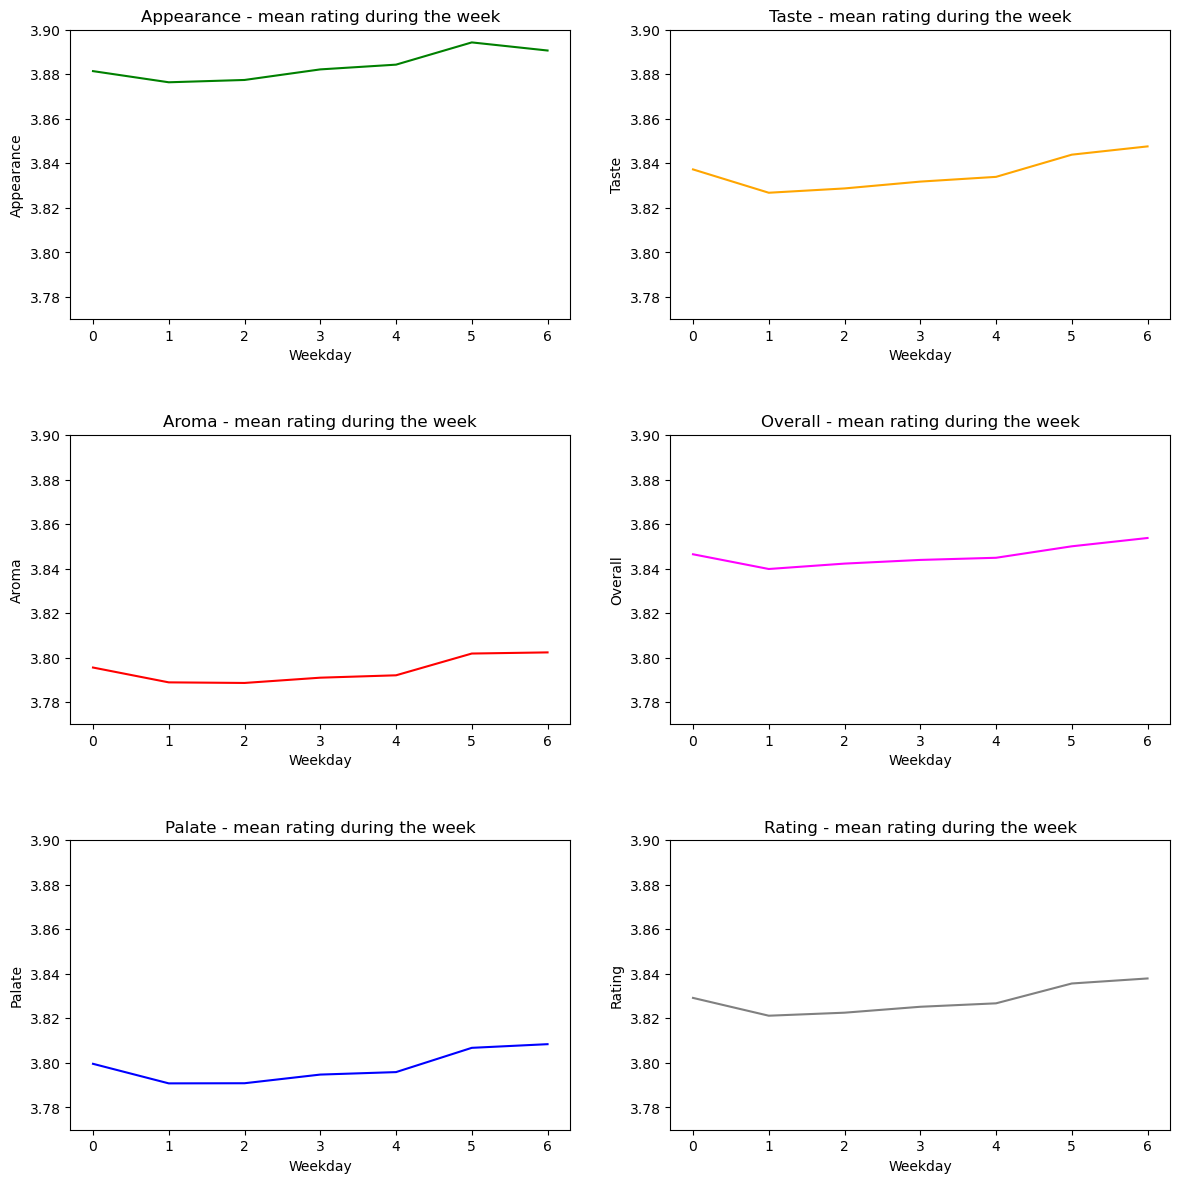

In [114]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)
    
for grading_index in range(len(grading_columns)):
    sns.lineplot(ax=axes[grading_index%3, grading_index//3], data = reviews_by_weekday[grading_columns[grading_index]], color = colors[grading_columns[grading_index]])
    axes[grading_index%3, grading_index//3].set_ylim([3.77,3.9]) #set the same interval for y axis
    axes[grading_index%3, grading_index//3].set_title(grading_columns[grading_index] + ' - mean rating during the week')
    

# set figure size
fig.set_size_inches(11, 11)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)

##### Monthly analysis

We will now do a similar anlyisis, but on a monthly basis:

In [115]:
reviews['Month'] = reviews['Date'].apply(lambda x: x.month) #adding Month data

[Text(0.5, 1.0, 'Number of reviews per month')]

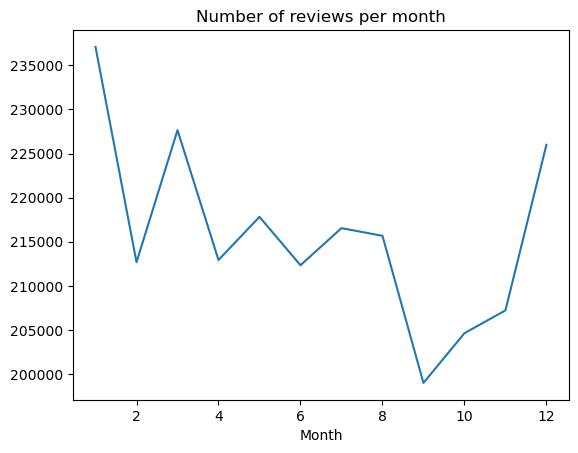

In [116]:
#Plotting number of reviews per each month
sns.lineplot(data = reviews.groupby('Month').size()).set(title = 'Number of reviews per month')

Have a glance at the dataframe obtained by grouping by month to see are differences between grades or alcohol levels.

In [117]:
reviews_by_month = reviews[grading_columns + ['Month']].groupby('Month').mean()
reviews_by_month

,Appearance,Aroma,Palate,Taste,Overall,Rating
Month,,,,,,
1,3.900863,3.813498,3.811059,3.854263,3.860183,3.844949
2,3.904521,3.812238,3.817095,3.855734,3.863684,3.846816
3,3.903220,3.808227,3.813836,3.851204,3.859058,3.842652
4,3.899602,3.807837,3.814537,3.852042,3.860129,3.842994
5,3.883954,3.793214,3.804928,3.838762,3.851730,3.830600
6,3.870564,3.781304,3.793192,3.827318,3.839407,3.818769
7,3.864726,3.778248,3.789722,3.820357,3.833005,3.813176
8,3.865168,3.775078,3.781544,3.816919,3.831686,3.811377
9,3.866959,3.775777,3.781065,3.817010,3.831456,3.812626


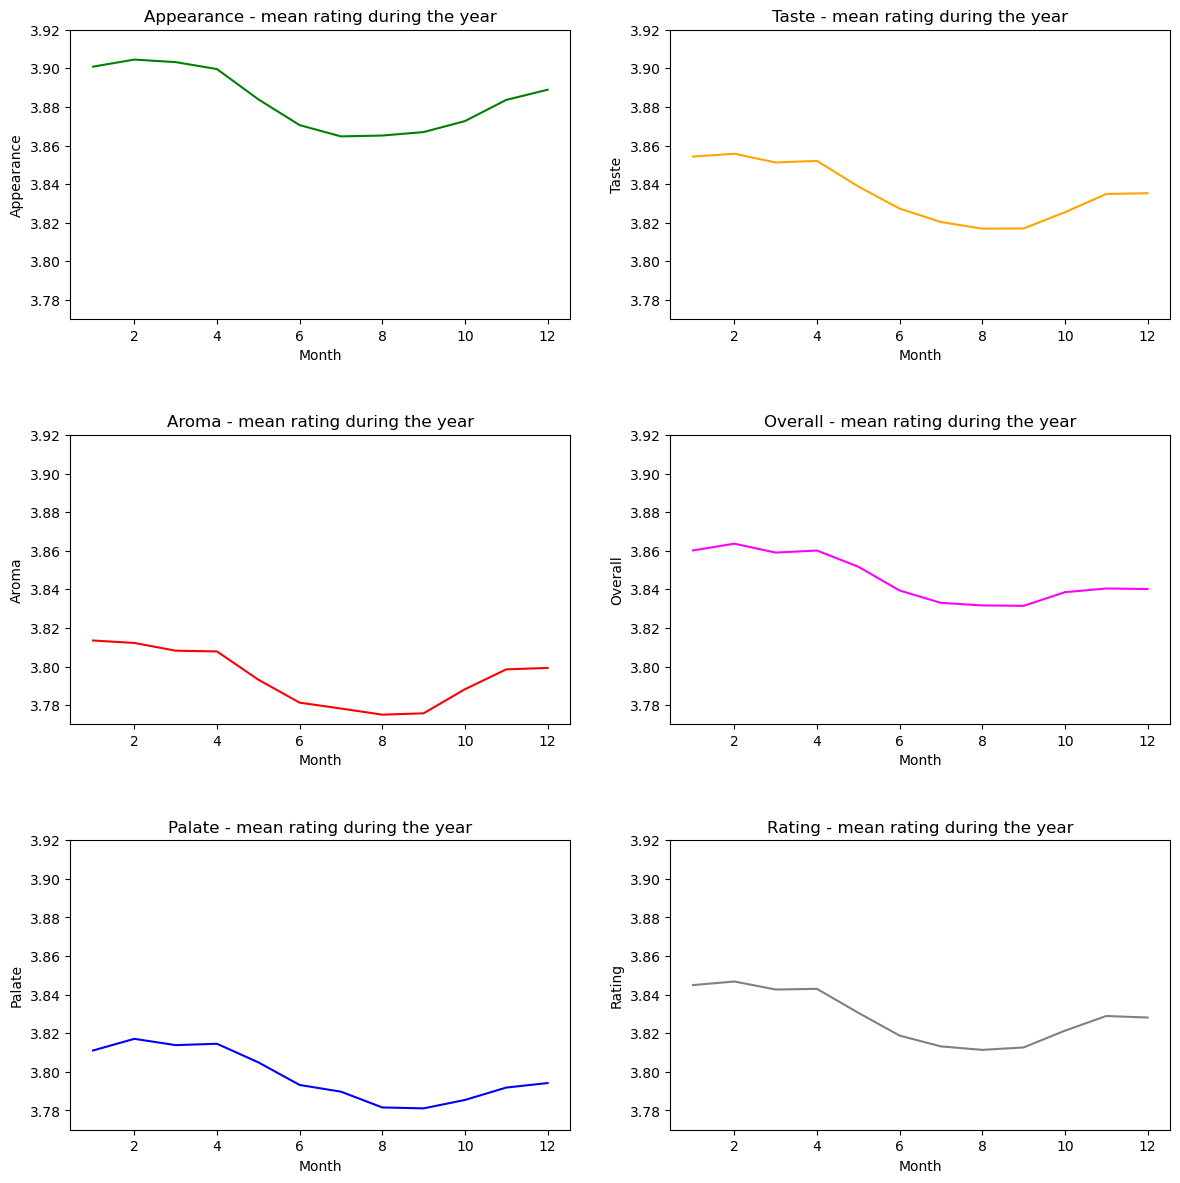

In [118]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)
    
for grading_index in range(len(grading_columns)):
    sns.lineplot(ax=axes[grading_index%3, grading_index//3], data = reviews_by_month[grading_columns[grading_index]], color = colors[grading_columns[grading_index]])
    axes[grading_index%3, grading_index//3].set_ylim([3.77,3.92]) #set the same interval for y axis
    axes[grading_index%3, grading_index//3].set_title(grading_columns[grading_index] + ' - mean rating during the year')
    

# set figure size
fig.set_size_inches(11, 11)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)